In [1]:
import sys
import torch
import math
from xray_gaussian_rasterization_voxelization import (
    GaussianRasterizationSettings,
    GaussianRasterizer,
    GaussianVoxelizationSettings,
    GaussianVoxelizer,
)

sys.path.append("./")
from r2_gaussian.gaussian.gaussian_model import GaussianModel
from r2_gaussian.dataset.cameras import Camera
from r2_gaussian.arguments import PipelineParams

In [2]:
from r2_gaussian.dataset import Scene
from r2_gaussian.gaussian import GaussianModel, render, query, initialize_gaussian

In [3]:
from argparse import ArgumentParser
from r2_gaussian.arguments import (
    ModelParams,
    PipelineParams,
    get_combined_args,
)

In [4]:
from argparse import Namespace

In [5]:
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)

pipeline = PipelineParams(parser)


# Namespace で引数を手動指定
args = Namespace(
    source_path="/home/maemaeko/imari_lab/r2_gaussian/data/synthetic_dataset/cone_ntrain_75_angle_360/0_chest_cone",
    model_path="/home/maemaeko/imari_lab/r2_gaussian/output/4c6defb3-7",
    data_device="cuda",
    scale_min=0.0005,
    scale_max=0.5,
    eval=True
)

dataset = model.extract(args)
scene = Scene(
    dataset
)

Reading camera 75/75 for train
Reading camera 100/100 for test
Loading Training Cameras
Loading Test Cameras


In [6]:
# Set up Gaussians
gaussians = GaussianModel(None)  # scale_bound will be loaded later
loaded_iter = initialize_gaussian(gaussians, dataset, -1)
scene.gaussians = gaussians

Loading trained model at iteration 30000


In [7]:
views = scene.getTrainCameras()
print("Number of views: ", len(views))

Number of views:  75


In [8]:
import copy
import numpy as np
import matplotlib.pyplot as plt

# 三点から平面を定義する関数
def plane_from_points(p1, p2, p3):
    # ベクトルを計算
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    v1 = p2 - p1
    v2 = p3 - p1
    # 法線ベクトルを計算
    normal = np.cross(v1, v2)
    normal = normal / np.linalg.norm(normal)  # 正規化
    return normal, p1

In [9]:
import numpy as np

def spherical_to_cartesian(theta, phi, radius):
    x  = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.array([x, y, z])

def look_at_transform(
        center,
        lookat,
        up,
    ):
    z = lookat - center

    z = z / np.linalg.norm(z)

    x = np.cross(up, z)
    if np.all(x == 0):
        x = np.cross(up, z + np.array([1e-6, 1e-6, 1e-6]))  # Avoid zero vector
    x = x / np.linalg.norm(x)

    y = np.cross(z, x)
    R = np.stack([x, y, z], axis=1)
    t = -R.T @ center
    view_matrix = np.eye(4)
    view_matrix[:3, :3] = R
    view_matrix[:3, 3] = t
    return view_matrix

def view_matrix_from_spherical(
        theta,
        phi,
        radius,
        lookat = np.array([0, 0, 0]),
        up = np.array([0, 0, 1])
    ):
    center = spherical_to_cartesian(theta, phi, radius)
    return look_at_transform(center, lookat, up)

def get_camera(theta, phi, radius, up=np.array([0, 0, 1])):
    theta = np.array(theta)
    phi = np.array(phi)
    w2c = view_matrix_from_spherical(theta, phi, radius, up=up)
    _r = w2c[:3, :3]
    _t = w2c[:3, 3]

    return Camera(
        colmap_id=65,
        scanner_cfg=None,
        R = _r,
        T = _t, 
        angle=0.8366643629487514,
        mode=1,
        FoVx=0.5565993180102227,
        FoVy=0.5565993180102227,
        image=torch.zeros((1, 512, 512)),
        image_name="none",
        uid=15,
    )

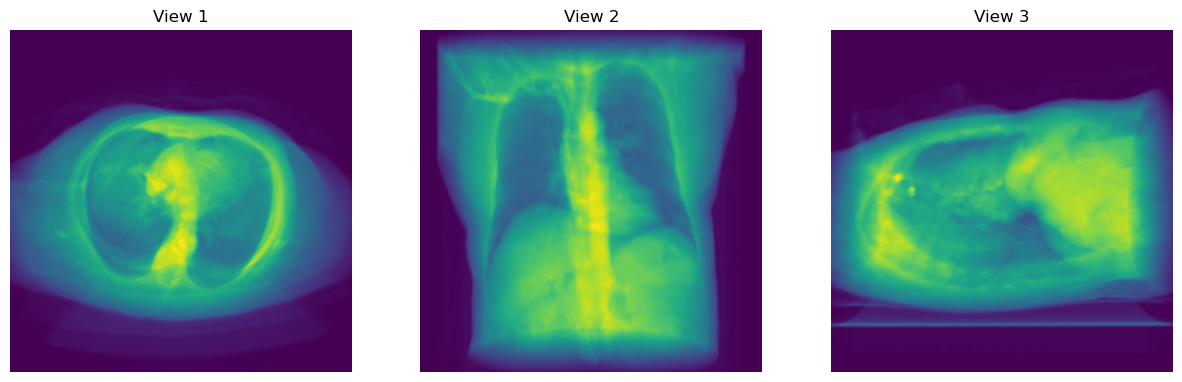

In [10]:
views = [get_camera(0, 0, 4, up=np.array([1, 0, 0])), get_camera(np.pi/2, 0, 4, up=np.array([1, 0, 0])), get_camera(np.pi/2, np.pi/2, 4, up=np.array([1, 0, 0]))]

renderings = []
for i, view in enumerate(views):
    rendering = render(view, gaussians, pipeline)["render"][0].detach().cpu().numpy()
    renderings.append(rendering)
    
plt.figure(figsize=(15, 5))
for i, r in enumerate(renderings):
    plt.subplot(1, len(renderings), i + 1)
    plt.imshow(r)
    plt.axis('off')
    plt.title(f"View {i + 1}")

In [11]:
def cut_gaussians_by_plane(gaussians, origin, normal, d=1e-1):
    with torch.no_grad():
        # 正規化された法線ベクトル
        normal = normal / np.linalg.norm(normal)
        normal = torch.from_numpy(normal).to(gaussians._xyz.device, dtype=gaussians._xyz.dtype)

        # originもtensorに変換
        origin = torch.from_numpy(origin).to(gaussians._xyz.device, dtype=gaussians._xyz.dtype)

        # 各centerから平面までの符号付き距離を計算
        distance = torch.abs(torch.matmul(gaussians._xyz - origin, normal))

        mask  = distance > d
        gaussians._density[mask] = -100

def cut_gaussians_beyond_plane(gaussians, origin, normal, d=1e-1):
    with torch.no_grad():
        # 正規化された法線ベクトル
        normal = normal / np.linalg.norm(normal)
        normal = torch.from_numpy(normal).to(gaussians._xyz.device, dtype=gaussians._xyz.dtype)

        # originもtensorに変換
        origin = torch.from_numpy(origin).to(gaussians._xyz.device, dtype=gaussians._xyz.dtype)

        # 各centerから平面までの符号付き距離を計算
        distance = torch.matmul(gaussians._xyz - origin, normal)

        mask  = distance < 0
        gaussians._density[mask] = -100

Text(0.5, 1.0, 'Image at z=0.01')

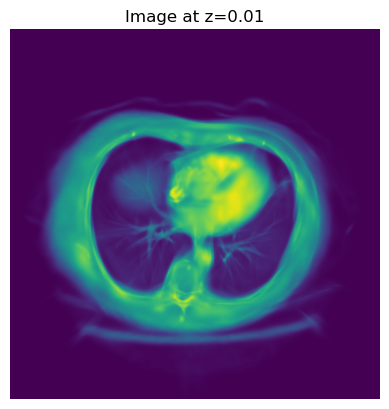

In [23]:
def get_image(theta, phi, radius, z, slice=True, up=np.array([1, 0, 0])):
    copy_gaussians = copy.deepcopy(gaussians)

    camera_center = spherical_to_cartesian(theta, phi, radius + z)
    normal_vector = camera_center / np.linalg.norm(camera_center)

    origin = np.array([0, 0, 0]) - normal_vector * z
    if slice:
        cut_gaussians_by_plane(copy_gaussians, origin, normal=normal_vector)
    else:
        cut_gaussians_beyond_plane(copy_gaussians, origin, normal=normal_vector)

    view = get_camera(theta, phi, radius, up=up)

    rendering = render(view, copy_gaussians, pipeline)["render"][0].detach().cpu().numpy()
    return rendering

rendering = get_image(0, 0, 4, 0.01)
plt.imshow(rendering)
plt.axis('off')
plt.title("Image at z=0.01")


In [24]:
import tqdm

In [25]:
# アニメーションを作成(gifファイルとして出力)
import imageio
import matplotlib.cm as cm

def create_gif(renderings, filename="output.gif", duration=0.1, colormap='jet'):
    """
    レンダリング結果からGIFアニメーションを作成
    
    Parameters:
    -----------
    renderings : list
        レンダリング結果の配列
    filename : str
        保存するファイル名
    duration : float
        フレーム間の時間（秒）
    colormap : str
        使用するカラーマップ名 ('jet', 'viridis', 'plasma'等)
    """
    # カラーマップを取得
    cmap = cm.get_cmap(colormap)
    
    # 画像配列を作成
    images = []
    for rendering in renderings:
        # 画像を0-1の範囲に正規化
        if rendering.min() != rendering.max():  # 分母が0にならないように確認
            normalized = (rendering - rendering.min()) / (rendering.max() - rendering.min())
        else:
            normalized = rendering
            
        # カラーマップを適用
        colored = cmap(normalized)
        
        # RGBA画像をRGB uint8に変換
        rgb_uint8 = (colored[:, :, :3] * 255).astype(np.uint8)
        images.append(rgb_uint8)
    
    # GIFとして保存
    imageio.mimsave(filename, images, duration=duration)
    print(f"GIFをファイル '{filename}' に保存しました")

# 使用例 - zを変化させたレンダリング結果からGIF作成
z_values = np.linspace(-1, 1, 50)  # フレーム数を50に減らして処理速度向上
renderings_slice = []
renderings = []

for z in tqdm.tqdm(z_values, desc="Z平面でのレンダリング"):
    rendering = get_image(0, 0, 4, z, slice=False)
    renderings.append(rendering)

    rendering = get_image(0, 0, 4, z, slice=True)
    renderings_slice.append(rendering)

# GIF作成（複数のカラーマップでテスト）
create_gif(renderings_slice, filename="slices_jet.gif", duration=0.1, colormap='jet')
create_gif(renderings_slice, filename="slices_viridis.gif", duration=0.1, colormap='viridis')

create_gif(renderings, filename="beyond_jet.gif", duration=0.1, colormap='jet')
create_gif(renderings, filename="beyond_viridis.gif", duration=0.1, colormap='viridis')



Z平面でのレンダリング: 100%|██████████| 50/50 [00:00<00:00, 80.12it/s]
/tmp/ipykernel_15287/2858116868.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


GIFをファイル 'slices_jet.gif' に保存しました
GIFをファイル 'slices_viridis.gif' に保存しました
GIFをファイル 'beyond_jet.gif' に保存しました
GIFをファイル 'beyond_viridis.gif' に保存しました


In [21]:
# 使用例 - thetaを変化させたレンダリング結果からGIF作成
theta_values = np.linspace(np.pi / 2, 0, 50)  # フレーム数を50に減らして処理速度向上

#phi_values = np.linspace(0, 2 * np.pi, 50)
renderings_theta_phi = []
for theta in tqdm.tqdm(theta_values, desc="ThetaとPhiでのレンダリング"):
    #for phi in phi_values:
    rendering = get_image(theta, 0, 4, 0.01)
    renderings_theta_phi.append(rendering)

# GIF作成（複数のカラーマップでテスト）
create_gif(renderings_theta_phi, filename="theta_jet.gif", duration=0.1, colormap='jet')
create_gif(renderings_theta_phi, filename="theta_viridis.gif", duration=0.1, colormap='viridis')

ThetaとPhiでのレンダリング: 100%|██████████| 50/50 [00:00<00:00, 147.10it/s]
/tmp/ipykernel_15287/2858116868.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


GIFをファイル 'theta_jet.gif' に保存しました
GIFをファイル 'theta_viridis.gif' に保存しました


In [28]:
# 使用例 - phiを変化させたレンダリング結果からGIF作成
phi_values = np.linspace(0, np.pi, 50)  # フレーム数を50に減らして処理速度向上
renderings_phi = []
for phi in tqdm.tqdm(phi_values, desc="Phiでのレンダリング"):
    rendering = get_image(np.pi/2, phi, 10, 0.01, up=np.array([0, 1, 0]))
    renderings_phi.append(rendering)
# GIF作成（複数のカラーマップでテスト）
create_gif(renderings_phi, filename="phi_jet.gif", duration=0.1, colormap='jet')
create_gif(renderings_phi, filename="phi_viridis.gif", duration=0.1, colormap='viridis')

Phiでのレンダリング: 100%|██████████| 50/50 [00:00<00:00, 126.52it/s]
/tmp/ipykernel_15287/2858116868.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


GIFをファイル 'phi_jet.gif' に保存しました
GIFをファイル 'phi_viridis.gif' に保存しました


/tmp/ipykernel_1016/3545092522.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


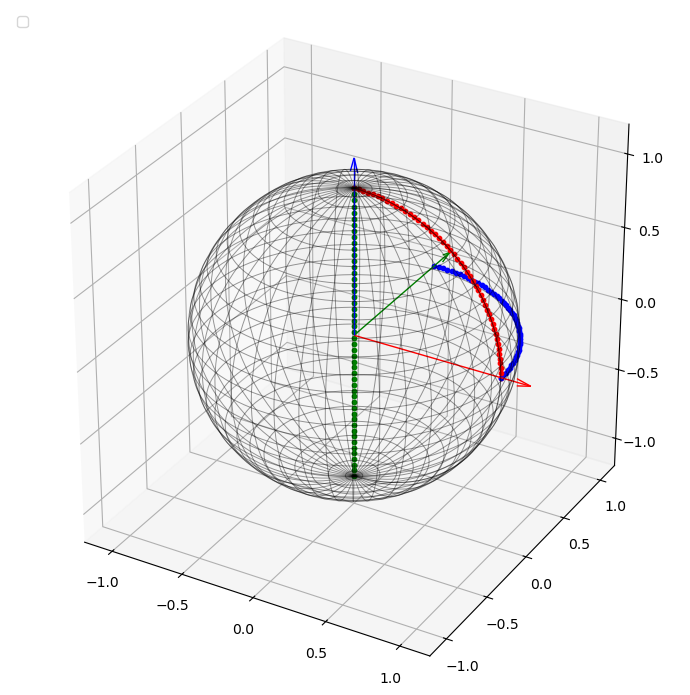

In [ ]:
# 球面座標系の可視化（ブラッシュアップ版）

import numpy as np
import matplotlib.pyplot as plt

# 球面座標系 (r, theta, phi) からデカルト座標 (x, y, z) への変換
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

# パラメータ範囲
r = 1
theta = np.linspace(0, np.pi, 60)      # 分解能を上げる
phi = np.linspace(0, 2 * np.pi, 120)

# メッシュグリッド作成
theta_grid, phi_grid = np.meshgrid(theta, phi)

# デカルト座標に変換
x, y, z = spherical_to_cartesian(r, theta_grid, phi_grid)

# 3Dプロット
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(x, y, z, color='k', linewidth=0.7, alpha=0.4)

# 球面座標の軸を描画
ax.quiver(0, 0, 0, 1.2, 0, 0, color='r', arrow_length_ratio=0.08, linewidth=1)
ax.quiver(0, 0, 0, 0, 1.2, 0, color='g', arrow_length_ratio=0.08, linewidth=1)
ax.quiver(0, 0, 0, 0, 0, 1.2, color='b', arrow_length_ratio=0.08, linewidth=1)

# theta, phi の例点をプロット
# sample_theta = np.pi / 4
# sample_phi = np.pi / 3
# sample_x, sample_y, sample_z = spherical_to_cartesian(r, sample_theta, sample_phi)
# ax.scatter(sample_x, sample_y, sample_z, color='magenta', s=80, label='(θ, φ) example')

z_values = np.linspace(-1, 1, 50)  # フレーム数を50に減らして処理速度向上
for z in z_values:
    sample_x, sample_y, sample_z = spherical_to_cartesian(r, 0, 0)
    look_at_transform
    ax.scatter(sample_x, sample_y, z, color='green', s=10)


# theta_values = np.linspace(np.pi / 2, 0, 50) 
# phi_values = np.zeros_like(theta_values)
# for theta, phi in zip(theta_values, phi_values):
#     sample_x, sample_y, sample_z = spherical_to_cartesian(r, theta, phi)
#     ax.scatter(sample_x, sample_y, sample_z, color='red', s=10)


# phi_values = np.linspace(0, np.pi/2, 50)
# theta_values = np.ones_like(phi_values) * np.pi / 2 
# for theta, phi in zip(theta_values, phi_values):
#     sample_x, sample_y, sample_z = spherical_to_cartesian(r, theta, phi)
#     ax.scatter(sample_x, sample_y, sample_z, color='blue', s=10)



# ラベル・タイトル
# ax.set_xlabel('X', fontsize=12)
# ax.set_ylabel('Y', fontsize=12)
# ax.set_zlabel('Z', fontsize=12)
# ax.set_title('球面座標系の可視化', fontsize=15)
ax.set_box_aspect([1,1,1])

# 凡例
ax.legend(loc='upper left')

# スケール調整
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])

plt.tight_layout()
plt.show()